In [2]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
! kaggle datasets download uciml/sms-spam-collection-dataset

  0% 0.00/211k [00:00<?, ?B/s]
100% 211k/211k [00:00<00:00, 59.1MB/s]


In [4]:
! unzip sms-spam-collection-dataset.zip

Archive:  sms-spam-collection-dataset.zip
  inflating: spam.csv                


In [75]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from math import log, sqrt
import pandas as pd
import numpy as np
import re
from collections import defaultdict
%matplotlib inline

In [7]:
mails = pd.read_csv('/content/spam.csv', encoding = 'latin-1')
mails.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [8]:
mails.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1, inplace = True)
mails.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
mails.rename(columns = {'v1': 'labels', 'v2': 'message'}, inplace = True)
mails.head()

,labels,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [16]:
mails.describe().T

,count,unique,top,freq
labels,5572,2,ham,4825
message,5572,5169,"Sorry, I'll call later",30


In [18]:
mails['labels'].value_counts()

ham     4825
spam     747
Name: labels, dtype: int64

In [19]:
mails['labels'] = mails['labels'].map({'ham': 0, 'spam':1})
mails.head()

,labels,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [20]:
trainIdx, testIdx = [], []
for i in range(mails.shape[0]):
  if np.random.uniform(0, 1) < 0.75:
    trainIdx.append(i)
  else:
    testIdx.append(i)
train = mails.loc[trainIdx]
test = mails.loc[testIdx]

In [24]:
train.reset_index(inplace = True)
train.drop(['index'], axis = 1, inplace = True)
train.head()

,labels,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [26]:
test.reset_index(inplace = True)
test.drop(['index'], axis = 1, inplace = True)
test.head()

,labels,message
0,0,Even my brother is not like to speak with me. ...
1,0,As per your request 'Melle Melle (Oru Minnamin...
2,1,WINNER!! As a valued network customer you have...
3,1,Had your mobile 11 months or more? U R entitle...
4,0,I've been searching for the right words to tha...


In [29]:
train['labels'].value_counts()


0    3640
1     552
Name: labels, dtype: int64

In [30]:
test['labels'].value_counts()

0    1185
1     195
Name: labels, dtype: int64

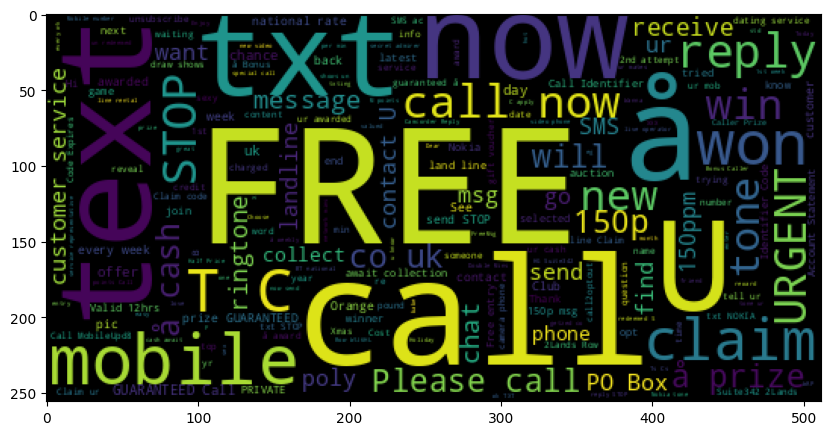

In [34]:
spam_words = ' '.join(list(mails[mails['labels'] == 1]['message']))
spam_wc = WordCloud(width = 512, height = 256).generate(spam_words)
plt.figure(figsize = (10, 8))
plt.imshow(spam_wc)
plt.show()

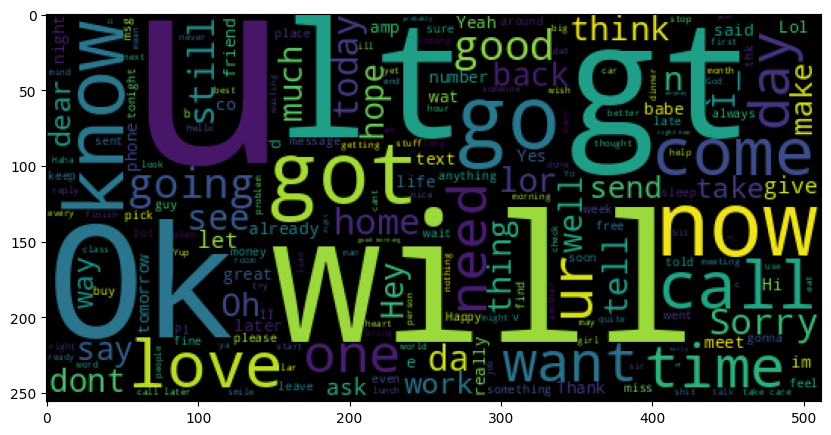

In [36]:
ham_words = ' '.join(list(mails[mails['labels'] == 0]['message']))
ham_wc = WordCloud(width = 512, height = 256).generate(ham_words)
plt.figure(figsize = (10, 8))
plt.imshow(ham_wc)
plt.show()

In [64]:
def message_preprocess(message, gram = 2):
  message = message.lower()
  words = word_tokenize(message)

  words = [word for word in words if len(word)>2]

  if gram > 1:
    w = []
    for i in range(len(words)-gram+1):
      words+=[''.join(words[i:i+gram])]
      

  sw = stopwords.words('english')
  words = [word for word in words if word not in sw]

  stemmer = PorterStemmer()
  words = [stemmer.stem(word) for word in words]

  return words
    


In [58]:

print(train['message'][0])
print(message_preprocess(train['message'][0], 1))

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
['jurong', 'point', 'crazi', 'avail', 'bugi', 'great', 'world', 'buffet', '...', 'cine', 'got', 'amor', 'wat', '...']


In [79]:
class SpamClassifier(object):
    def __init__(self, trainData, method = 'tf-idf'):
        self.mails, self.labels = trainData['message'], trainData['labels']
        self.method = method

    def train(self):
        self.calc_TF_and_IDF()
        if self.method == 'tf-idf':
            self.calc_TF_IDF()
        else:
            self.calc_prob()

    def calc_TF_and_IDF(self):
        noOfMessages = self.mails.shape[0]
        self.spam_mails, self.ham_mails = self.labels.value_counts()[1], self.labels.value_counts()[0]
        self.total_mails = self.spam_mails + self.ham_mails
        self.spam_words = 0
        self.ham_words = 0
        self.tf_spam = defaultdict(int)
        self.tf_ham = defaultdict(int)
        self.idf_spam = defaultdict(int)
        self.idf_ham = defaultdict(int)
        for i in range(noOfMessages):
            message_processed = message_preprocess(self.mails[i])
            count = list() #To keep track of whether the word has ocured in the message or not.
                           #For IDF
            for word in message_processed:
                if self.labels[i]:
                    self.tf_spam[word] +=  1
                    self.spam_words += 1
                else:
                    self.tf_ham[word] += 1
                    self.ham_words += 1
                if word not in count:
                    count += [word]
            for word in count:
                if self.labels[i]:
                    self.idf_spam[word] += 1
                else:
                    self.idf_ham[word] += 1

    def calc_TF_IDF(self):
        self.prob_spam = defaultdict(int)
        self.prob_ham = defaultdict(int)
        self.sum_tf_idf_spam = 0
        self.sum_tf_idf_ham = 0
        for word in self.tf_spam:
            self.prob_spam[word] = (self.tf_spam[word]) * log((self.spam_mails + self.ham_mails) \
                                                          / (self.idf_spam[word] + self.idf_ham[word]))
            self.sum_tf_idf_spam += self.prob_spam[word]
        for word in self.tf_spam:
            self.prob_spam[word] = (self.prob_spam[word] + 1) / (self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
            
        for word in self.tf_ham:
            self.prob_ham[word] = (self.tf_ham[word]) * log((self.spam_mails + self.ham_mails) \
                                                          / (self.idf_spam[word] + self.idf_ham[word]))
            self.sum_tf_idf_ham += self.prob_ham[word]
        for word in self.tf_ham:
            self.prob_ham[word] = (self.prob_ham[word] + 1) / (self.sum_tf_idf_ham + len(list(self.prob_ham.keys())))
            
    
        self.prob_spam_mail, self.prob_ham_mail = self.spam_mails / self.total_mails, self.ham_mails / self.total_mails 

    def calc_prob(self):
        self.prob_spam = defaultdict(int)
        self.prob_ham = defaultdict(int)
        for word in self.tf_spam:
            self.prob_spam[word] = (self.tf_spam[word] + 1) / (self.spam_words + \
                                                                len(list(self.tf_spam.keys())))
        for word in self.tf_ham:
            self.prob_ham[word] = (self.tf_ham[word] + 1) / (self.ham_words + \
                                                                len(list(self.tf_ham.keys())))
        self.prob_spam_mail, self.prob_ham_mail = self.spam_mails / self.total_mails, self.ham_mails / self.total_mails 

                    
    def classify(self, processed_message):
        pSpam, pHam = 0, 0
        for word in processed_message:                
            if word in self.prob_spam:
                pSpam += log(self.prob_spam[word])
            else:
                if self.method == 'tf-idf':
                    pSpam -= log(self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
                else:
                    pSpam -= log(self.spam_words + len(list(self.prob_spam.keys())))
            if word in self.prob_ham:
                pHam += log(self.prob_ham[word])
            else:
                if self.method == 'tf-idf':
                    pHam -= log(self.sum_tf_idf_ham + len(list(self.prob_ham.keys()))) 
                else:
                    pHam -= log(self.ham_words + len(list(self.prob_ham.keys())))
            pSpam += log(self.prob_spam_mail)
            pHam += log(self.prob_ham_mail)
        return pSpam >= pHam
    
    def predict(self, testData):
        result = defaultdict(int)
        for (i, message) in enumerate(testData):
            processed_message = message_preprocess(message)
            result[i] = int(self.classify(processed_message))
        return result
  

In [66]:
def metrics(labels, predictions):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels[i] == 1 and predictions[i] == 1)
        true_neg += int(labels[i] == 0 and predictions[i] == 0)
        false_pos += int(labels[i] == 0 and predictions[i] == 1)
        false_neg += int(labels[i] == 1 and predictions[i] == 0)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)

In [80]:
sc_tf_idf = SpamClassifier(train, 'tf-idf')
sc_tf_idf.train()
preds_tf_idf = sc_tf_idf.predict(test['message'])
metrics(test['labels'], preds_tf_idf)

Precision:  0.958041958041958
Recall:  0.7025641025641025
F-score:  0.8106508875739644
Accuracy:  0.9536231884057971


In [78]:
message = message_preprocess('Congratulations ur awarded laptop')
sc_tf_idf.classify(message)

True